# Case 2. Diabetic Retinopathy Analysis
Name: Dmytro Izotov<br>
Last edited: 26.02.2019<br>
Cognitive Systems for Health Technology Applications<br>
[Helsinki Metropolia University of Applied Sciences](http://www.metropolia.fi/en/)<br>
Based on Sakari's [demo](https://www.kaggle.com/sakarilukkarinen/demo-04-binary-classifier)

## 1. Objectives

The aim of this assignment is to learn to use convolutional neural networks to classify medical
images. The main objective is to use convolutional neural networks to create a binary classifier for diabetic retinopathy images with the use of provided [DATA](https://github.com/Nomikxyz/retinopathy-dataset)

## 2. Required libraries

In [1]:
import pandas as pd
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras import Sequential
from keras.layers import Conv2D, Activation, MaxPooling2D, Dropout, Flatten, Dense
from keras import optimizers
from time import time, localtime, strftime
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, cohen_kappa_score, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve

Using TensorFlow backend.


## 3. Data description and preprocessing

In [2]:
# Here I'm using preprocessed data set from Kaggle.  

df = pd.read_csv(r"C://Users//Dizotoff//Desktop//isle//case 2//newTrainLabels.csv")

# Column 'level' correspond to the severity of the desease (level = diabetic retinopathy level (0 = Healthy, ..., 
# 4 = Severe), lets convert those to binaries

df['level'] = 1*(df['level'] > 0)
df.describe()

,level,MB
count,35124.000000,35124.000000
mean,0.265232,0.139589
std,0.441463,0.017513
min,0.000000,0.023632
25%,0.000000,0.128283
50%,0.000000,0.140632
75%,1.000000,0.151493
max,1.000000,0.218401


In [32]:
# Resample and take only 2000 first rows
df = df.sample(n = 2000, random_state = 2019)
df.shape

(2000, 3)

In [6]:
# Create image data generator
from keras.preprocessing.image import ImageDataGenerator
# Scale all images by 1/255 
datagen = ImageDataGenerator(
    rescale=1./255, 
    validation_split = 0.25)

# Data generator for training
train_generator = datagen.flow_from_dataframe(
    dataframe = df, 
    directory = "C://Users//Dizotoff//Desktop//isle//case 2//300_train",
    has_ext = False,
    x_col = "image", 
    y_col = "level", 
    class_mode = "binary", 
    target_size = (100, 100), 
    batch_size = 16,
    subset = 'training')

# Data generator for validation
valid_generator = datagen.flow_from_dataframe(
    dataframe = df, 
    directory = "C://Users//Dizotoff//Desktop//isle//case 2//300_train",
    has_ext = False,
    x_col = "image", 
    y_col = "level", 
    class_mode = "binary", 
    target_size = (100, 100), 
    batch_size = 16,
    subset = 'validation')

Found 1481 images belonging to 2 classes.
Found 519 images belonging to 2 classes.


## 4. Modeling and compilation




In [7]:
# After some tinkering with model structure I decided to leave this variation with standart 32 filter of size 3x3.
# Sigmoid on the last layer because that's a binary problem, no dropout. 

model = Sequential()
model.add(Conv2D(32, (3, 3), activation = 'relu', input_shape = (100, 100, 3)))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Conv2D(32, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Conv2D(32, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Flatten())
model.add(Dense(512, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer = optimizers.RMSprop(lr=1e-4),
             loss='binary_crossentropy', 
              metrics = ["accuracy"])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 98, 98, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 47, 47, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 21, 21, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 10, 10, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3200)              0         
__________

In [8]:
from time import time, localtime, strftime
# Testing with localtime and strftime
print(localtime())
print(strftime('%Y-%m-%d-%H%M%S', localtime()))

time.struct_time(tm_year=2019, tm_mon=2, tm_mday=26, tm_hour=12, tm_min=1, tm_sec=28, tm_wday=1, tm_yday=57, tm_isdst=0)
2019-02-26-120128


## 5. Training and Validation

In [9]:
# Calculate how many batches are needed to go through whole train and validation set
STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n // valid_generator.batch_size
N = 10 # Number of epochs

# Train and count time
model_name = strftime('Case2-%Y-%m-%d-%H%M%S.h5', localtime())
t1 = time()
h = model.fit_generator(generator = train_generator,
                    steps_per_epoch = STEP_SIZE_TRAIN,
                    validation_data = valid_generator,
                    validation_steps = STEP_SIZE_VALID,
                    epochs = N,
                    verbose = 2)
t2 = time()
elapsed_time = (t2 - t1)

# Save the model
model.save(model_name)
print('')
print('Model saved to file:', model_name)
print('')

# Print the total elapsed time and average time per epoch in format (hh:mm:ss)
t_total = strftime('%H:%M:%S', localtime(t2 - t1))
t_per_e = strftime('%H:%M:%S', localtime((t2 - t1)/N))
print('Total elapsed time for {:d} epochs: {:s}'.format(N, t_total))
print('Average time per epoch:             {:s}'.format(t_per_e))

Epoch 1/10
 - 68s - loss: 0.5952 - acc: 0.7228 - val_loss: 0.5650 - val_acc: 0.7500
Epoch 2/10
 - 63s - loss: 0.5887 - acc: 0.7296 - val_loss: 0.5619 - val_acc: 0.7535
Epoch 3/10
 - 62s - loss: 0.5907 - acc: 0.7240 - val_loss: 0.5796 - val_acc: 0.7376
Epoch 4/10
 - 64s - loss: 0.5932 - acc: 0.7241 - val_loss: 0.5344 - val_acc: 0.7753
Epoch 5/10
 - 64s - loss: 0.5733 - acc: 0.7379 - val_loss: 0.5982 - val_acc: 0.7336
Epoch 6/10
 - 68s - loss: 0.5870 - acc: 0.7234 - val_loss: 0.5602 - val_acc: 0.7535
Epoch 7/10
 - 66s - loss: 0.5812 - acc: 0.7289 - val_loss: 0.5599 - val_acc: 0.7614
Epoch 8/10
 - 66s - loss: 0.5753 - acc: 0.7347 - val_loss: 0.5687 - val_acc: 0.7515
Epoch 9/10
 - 63s - loss: 0.5912 - acc: 0.7165 - val_loss: 0.5698 - val_acc: 0.7515
Epoch 10/10
 - 64s - loss: 0.5701 - acc: 0.7352 - val_loss: 0.5484 - val_acc: 0.7634

Model saved to file: Case2-2019-02-26-120128.h5

Total elapsed time for 10 epochs: 02:10:48
Average time per epoch:             02:01:04


## 6. Evaluation

<Figure size 432x288 with 0 Axes>

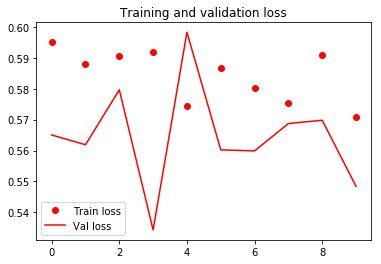

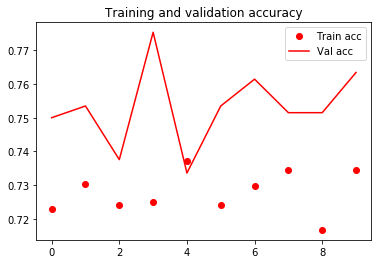

<Figure size 432x288 with 0 Axes>

In [37]:
acc = h.history['acc']
val_acc = h.history['val_acc']
loss = h.history['loss']
val_loss = h.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, loss, 'ro', label='Train loss')
plt.plot(epochs, val_loss, 'r', label='Val loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'ro', label='Train acc')
plt.plot(epochs, val_acc, 'r', label='Val acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

## 7. Results and Discussion

In [13]:
# Calculate the true and predicted values
y_true = valid_generator.classes
y_true = y_true[:16*20]
predict = model.predict_generator(valid_generator, steps=20)
y_pred = predict > 0.5


In [14]:
# Calculate and print the metrics results
from sklearn.metrics import confusion_matrix, cohen_kappa_score, classification_report

cm = confusion_matrix(y_true, y_pred)
print('Confusion matrix:')
print(cm)
print('')

cr = classification_report(y_true, y_pred)
print('Classification report:')
print(cr)
print('')

Confusion matrix:
[[243   0]
 [ 77   0]]

Classification report:
              precision    recall  f1-score   support

           0       0.76      1.00      0.86       243
           1       0.00      0.00      0.00        77

   micro avg       0.76      0.76      0.76       320
   macro avg       0.38      0.50      0.43       320
weighted avg       0.58      0.76      0.66       320




C:\Users\Dizotoff\Anaconda3\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [28]:
a = accuracy_score(y_true, predict > dp)
print('Accuracy: {:.4f}'.format(a))

Accuracy: 0.6813
